# Imports

In [1]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
pd.set_option('display.max_columns', None)

# Inladen opgeschoonde dataset

In [2]:
storingen = pd.read_csv("clean.csv")
storingen = storingen.convert_dtypes()
storingen.head()

stm_prioriteit stm_aanntpl_tijd stm_progfh_in_duur stm_sap_meldtijd  \
0               9         00:00:00         99999999.0         09:00:00   
1               9         00:00:00         99999999.0         12:35:00   
2               9         00:00:00         99999999.0         16:40:00   
3               9         00:00:00         99999999.0         22:30:00   
4               9         00:00:00         99999999.0         11:23:00   

   stm_fh_duur  
0            0  
1           51  
2           40  
3            6  
4            7

# Data cleanup

Hieronder worden de lege values opgevuld met prioriteit 9, dit omdat er ten eerste maar 112 values leeg zijn, en ten tweede omdat wij er vanuit gaan dat als de prioriteit niet is ingevuld, het geen belangrijk probleem is geweest.

In [3]:
storingen['stm_prioriteit'] = storingen['stm_prioriteit'].fillna(9)
storingen['stm_prioriteit'] = storingen['stm_prioriteit'].astype(str)
storingen['stm_prioriteit'] = 'prio: ' + storingen['stm_prioriteit'] 
dummies = pd.get_dummies(storingen['stm_prioriteit'])
storingen = storingen.drop('stm_prioriteit', axis = 1)
storingen = storingen.join(dummies)
storingen.head()

stm_aanntpl_tijd stm_progfh_in_duur stm_sap_meldtijd  stm_fh_duur  prio: 1  \
0         00:00:00         99999999.0         09:00:00            0        0   
1         00:00:00         99999999.0         12:35:00           51        0   
2         00:00:00         99999999.0         16:40:00           40        0   
3         00:00:00         99999999.0         22:30:00            6        0   
4         00:00:00         99999999.0         11:23:00            7        0   

   prio: 2  prio: 4  prio: 5  prio: 8  prio: 9  
0        0        0        0        0        1  
1        0        0        0        0        1  
2        0        0        0        0        1  
3        0        0        0        0        1  
4        0        0        0        0        1

Hieronder word stm_fh_duur opgeschoond. Allereest verwijderen we alles waarbij de duur 0 is, omdat we niet geinteresseerd zijn in dit voorspellen, omdat de dienstregeling hierdoor niet verstoord wordt. Darnaast verwijderen we ook alle sterke outliers, zodat de data minder ruis bevat.

In [4]:
storingen = storingen[storingen.stm_fh_duur != 0]
duur = storingen['stm_fh_duur']
# Omdat we alleen geïnteresseerd zijn in de storingen korter dan 1 dag, worden outliers automatisch verwijderd.
storingen = storingen[storingen.stm_fh_duur < 1440]

Hieronder worden alle tijden en data omgezet naar pure getallen, zodat het model hiermee kan werken.

In [5]:
storingen["stm_sap_meldtijd"] = storingen["stm_sap_meldtijd"].str.replace(":", "")
storingen = storingen[storingen.stm_sap_meldtijd != '']
storingen["stm_sap_meldtijd"] = storingen["stm_sap_meldtijd"].dropna()
storingen["stm_sap_meldtijd"] = storingen["stm_sap_meldtijd"].astype(int)

In [6]:
storingen["stm_aanntpl_tijd"] = storingen["stm_aanntpl_tijd"].str.replace(":", "")
storingen = storingen[storingen.stm_aanntpl_tijd != '']
storingen["stm_aanntpl_tijd"] = storingen["stm_aanntpl_tijd"].dropna()
storingen["stm_aanntpl_tijd"] = storingen["stm_aanntpl_tijd"].astype(int)

Ten slotte moeten de prognoses van de monteurs worden opgeschoond, zodat er een eerlijke vergelijking kan worden gemaakt tussen hun voorspellingen en die van het model.

In [7]:
storingen['stm_progfh_in_duur'] = storingen['stm_progfh_in_duur'].astype(str)
for index, row in storingen.iterrows():
    if row['stm_progfh_in_duur'].startswith("-"):
        row = 0
    if row['stm_progfh_in_duur'].endswith("-"):
        row = row[:-1]
storingen =  storingen[storingen.stm_progfh_in_duur.astype(str).apply(lambda x: x.isnumeric())]
storingen['stm_progfh_in_duur'] = storingen['stm_progfh_in_duur'].astype(int)
duur = storingen['stm_progfh_in_duur']
storingen = storingen[storingen.stm_progfh_in_duur < 1440]
storingen = storingen[storingen.stm_progfh_in_duur > 0]

<AxesSubplot:xlabel='stm_progfh_in_duur', ylabel='stm_fh_duur'>

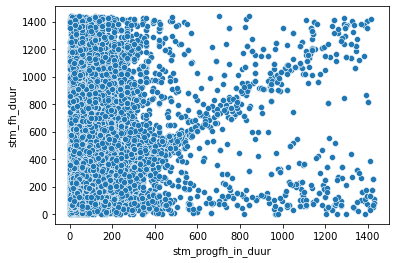

In [8]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_progfh_in_duur'])

# Baseline

De baseline is een simpel model dat constant het gemiddelde voorspelt, deze wordt gebruikt om in de beginfases van het model te testen.

In [9]:
storingen['baseline'] = storingen['stm_fh_duur']
gem =  sum(storingen['baseline'])/ len(storingen['baseline'])
storingen['baseline'] = storingen['baseline'].apply(lambda x : gem)
storingen['baseline'] = storingen['baseline'].astype(int)
mean_squared_error(storingen['stm_fh_duur'], storingen['baseline'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


105858.02953631543

In [10]:
np.sqrt(mean_squared_error(storingen['stm_fh_duur'], storingen['stm_progfh_in_duur']))
#mean_squared_error(storingen['stm_fh_duur'], storingen['stm_progfh_in_duur'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


361.1418111261789

# Model

## De variabelen voorbereiden

Allereerst moeten de x en de y worden bepaald.

In [11]:
x = storingen[['stm_sap_meldtijd', 'stm_aanntpl_tijd']]
y = storingen['stm_fh_duur']
y=y.astype('int')

Daarna worden deze opgesplitst in een train en een test set.

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y)

Nu we onze data goed hebben voorbereid, kunnen er modellen mee getraind worden. 
Allereerst trainen we een DecisionTreeClassifier, en bepalen we de score.

## Decision tree classifier

In [17]:
boom = DecisionTreeClassifier()
boom.fit(X_train, Y_train)
y_pred = boom.predict(X_test)
acc = boom.score(X_test, Y_test)
y_pred = boom.predict(X_test)


#print(classification_report(Y_test, y_pred))
print("Acc: " + str(acc))
pred = boom.predict([[171514, 180001], [133755, 144000] , [171022, 172656]])
print(pred)
#mean_absolute_error(Y_test, y_pred)
np.sqrt(mean_squared_error(Y_test, y_pred))

Acc: 0.3292058070025619
[113  75  50]


149.34998595059977

In [41]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
y_pred = random_forest.predict(X_test)
np.sqrt(mean_squared_error(Y_test, y_pred))

KeyboardInterrupt: 

Hieronder staat het script dat de beste waarde voor de max depth opzoekt. We zijn hier geintereseerd in de waarde waar de curve afvlakt.

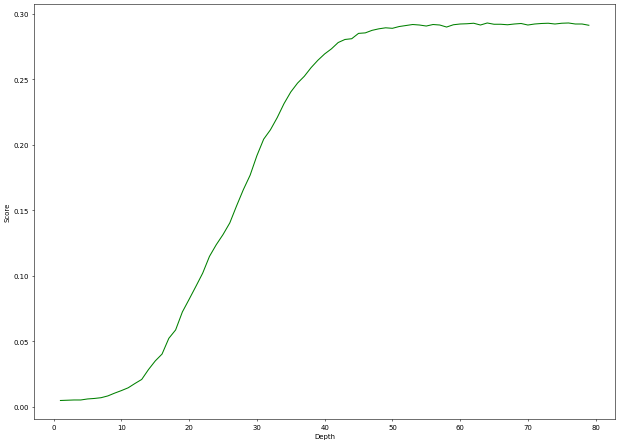

In [24]:
depths = []
scores = []

for depth in range(1, 80):
    boom = DecisionTreeClassifier(max_depth= depth)
    boom.fit(X_train, Y_train)
    y_pred = boom.predict(X_test)    
    depths.append(depth)
    scores.append(accuracy_score(Y_test, y_pred))   

plt.figure(figsize=(15,11), dpi=50)
plt.plot(depths, scores, color="g")
plt.xlabel("Depth")
plt.ylabel("Score")
plt.show()

Hieronder tonen we de boom, zodat we (visueel) kunnen zien of de boom niet overfit is.

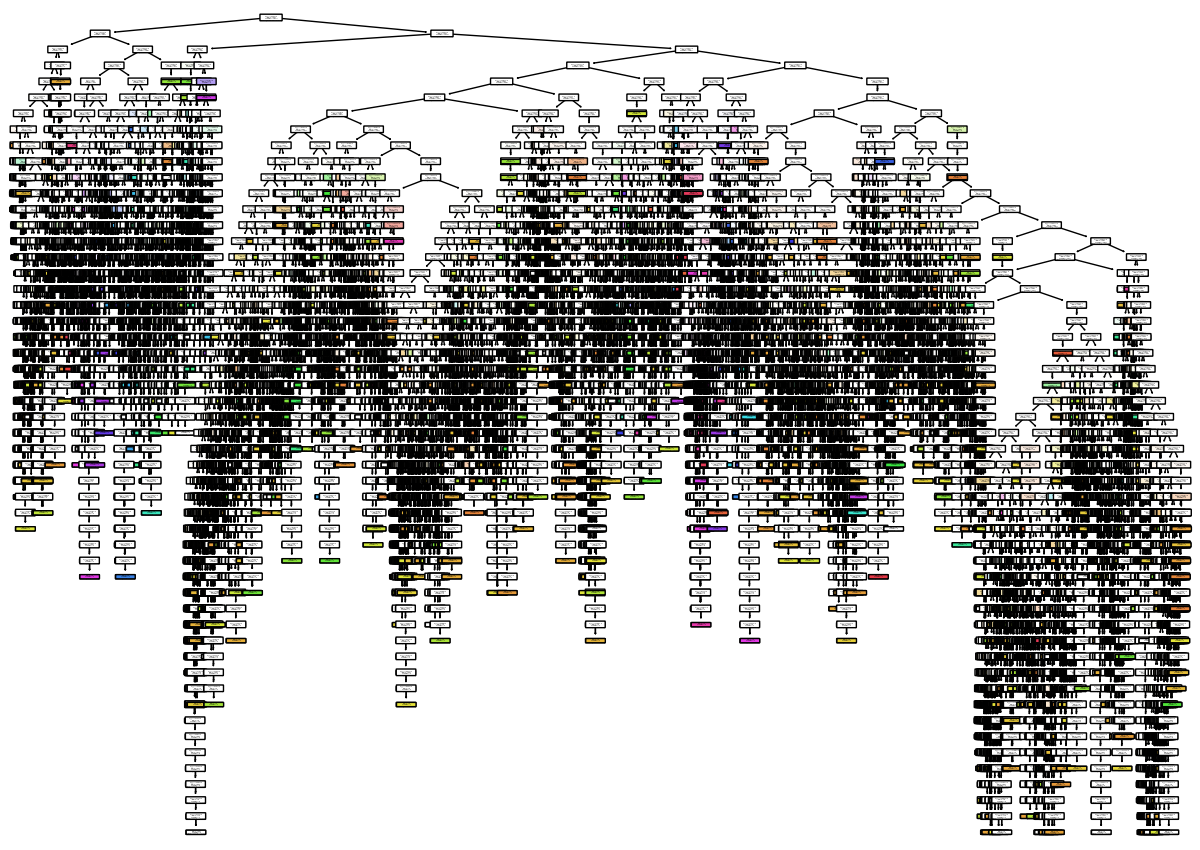

In [79]:
plt.figure(figsize=(15,11), dpi=100)

tree.plot_tree(boom, rounded=True, filled=True)

plt.show()

## K nearest neighbours model

Nu trainen we ook een KNN model. Dit doen we ten eerste om te kijken welk model beter scoort, maar ook als een controle of ons eerste model niet overfit is.

In [19]:
#x = storingen[['stm_sap_meldtijd', 'stm_aanntpl_tijd']].apply(lambda x:(x-x.min()) / (x.max()-x.min()))
#y = storingen[['stm_fh_duur']].apply(lambda x:(x-x.min()) / (x.max()-x.min()))
#y = y.astype('int')
#X_train, X_test, Y_train, Y_test = train_test_split(x, y)
knn = KNeighborsClassifier(n_neighbors = 53)
knn.fit(X_train, Y_train)
knn.set_params(weights="distance")
acc = knn.score(X_test, Y_test)
print("Model Accuracy: " + str(acc))
y_pred = knn.predict(X_test)
prediction = knn.predict([[171514, 180001], [133755, 144000] , [171022, 172656]])

print(prediction)
np.sqrt(mean_squared_error(Y_test, y_pred))
mean_absolute_error(Y_test, y_pred)

Model Accuracy: 0.3304867634500427
[113  75  38]


55.38699117563336

Hieronder staat het script dat berekent welke N waarde het beste scoort. Omdat N niet te laag mag zijn wegens risico op overfitting moet worden gekeken naar waar de grafiek het meeste afvlakt en niet naar de eerste piek.

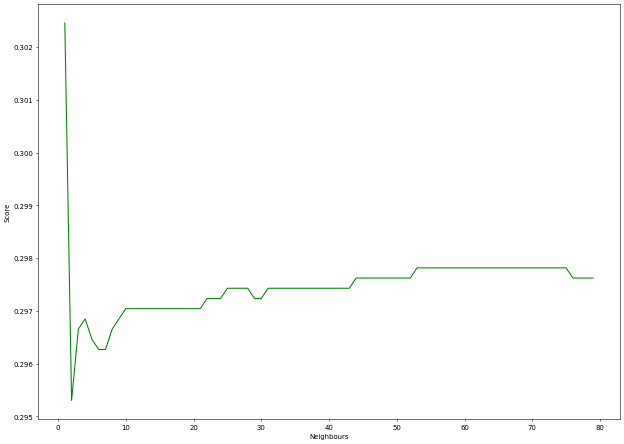

In [40]:
neighbours = []
scores = []
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
for neighbour in range(1, 80):
    knn.set_params(n_neighbors = neighbour, weights="distance")
    y_pred = knn.predict(X_test)    
    neighbours.append(neighbour)
    scores.append(accuracy_score(Y_test, y_pred))   

plt.figure(figsize=(15,11), dpi=50)
plt.plot(neighbours, scores, color="g")
plt.xlabel("Neighbours")
plt.ylabel("Score")
plt.show()

## Lineare regressie

Voordat er een lineare regressie model kan worden gemaakt, moet er eerst worden gekeken naar de correlaties met de target variabele, stm_fh_duur. We zijn geïnteresseerd in de hoogste correlaties. (zowel negatief als positief)

In [19]:
all_columns = storingen.columns.values
storingen[all_columns].corr()['stm_fh_duur'].sort_values()

prio: 2              -0.380276
stm_aanntpl_tijd     -0.272621
prio: 9              -0.035126
prio: 1               0.010317
prio: 8               0.014895
stm_sap_meldtijd      0.087426
prio: 4               0.178795
prio: 5               0.254084
stm_progfh_in_duur    0.289929
stm_fh_duur           1.000000
baseline                   NaN
Name: stm_fh_duur, dtype: float64

In [20]:
X=storingen[['prio: 2' , 'stm_aanntpl_tijd', 'prio: 1', 'prio: 4', 'stm_progfh_in_duur', 'prio: 5', 'stm_sap_meldtijd']]
Y=storingen['stm_fh_duur'].astype('int')
y=y.astype('int')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [21]:
reg=LinearRegression()
reg.fit(X_train,Y_train)
y_pred = reg.predict(X_test)
acc = reg.score(X_test, Y_test)
print("Model Accuracy: " + str(acc))
mean_absolute_error(Y_test, y_pred)
np.sqrt(mean_squared_error(Y_test, y_pred))

Model Accuracy: 0.3138890841999009


273.6070966728281

Naast een normale lineare lijn kunnen we ook een polynoom plotten om te kijken of deze beter scoort.

In [22]:
poly_reg=PolynomialFeatures()

X_poly=poly_reg.fit_transform(X_test)

poly_reg.fit(X_poly,Y_test)

lin_reg=LinearRegression()
lin_reg.fit(X_poly,Y_test)
acc = lin_reg.score(X_poly, Y_test)
print(acc)
#pred = math.trunc(lin_reg.predict(poly_reg.fit_transform(np.array([1, 100000, 0, 100, 0]).reshape(1,-1)))[0])
y_pred = lin_reg.predict(poly_reg.fit_transform(X_test))
np.sqrt(mean_squared_error(Y_test, y_pred))
#print(pred)

0.36573761007767047


263.06597081422007

In [ ]:
neighbours = []
scores = []

for degree in range(1, 80):
    poly_reg=PolynomialFeatures(degree = degree)
    X_poly=poly_reg.fit_transform(X_test)
    poly_reg.fit(X_poly,Y_test)
    lin_reg=LinearRegression()
    lin_reg.fit(X_poly,Y_test)
    X_grid=np.arange(min(X),max(X),0.1)
    X_grid=X_grid.reshape((len(X_grid),1))   
    neighbours.append(degree)
    scores.append(lin_reg.score(X_poly, y_test))   

plt.figure(figsize=(15,11), dpi=50)
plt.plot(neighbours, scores, color="g")
plt.xlabel("degrees")
plt.ylabel("Score")
plt.legend()

# Grafieken

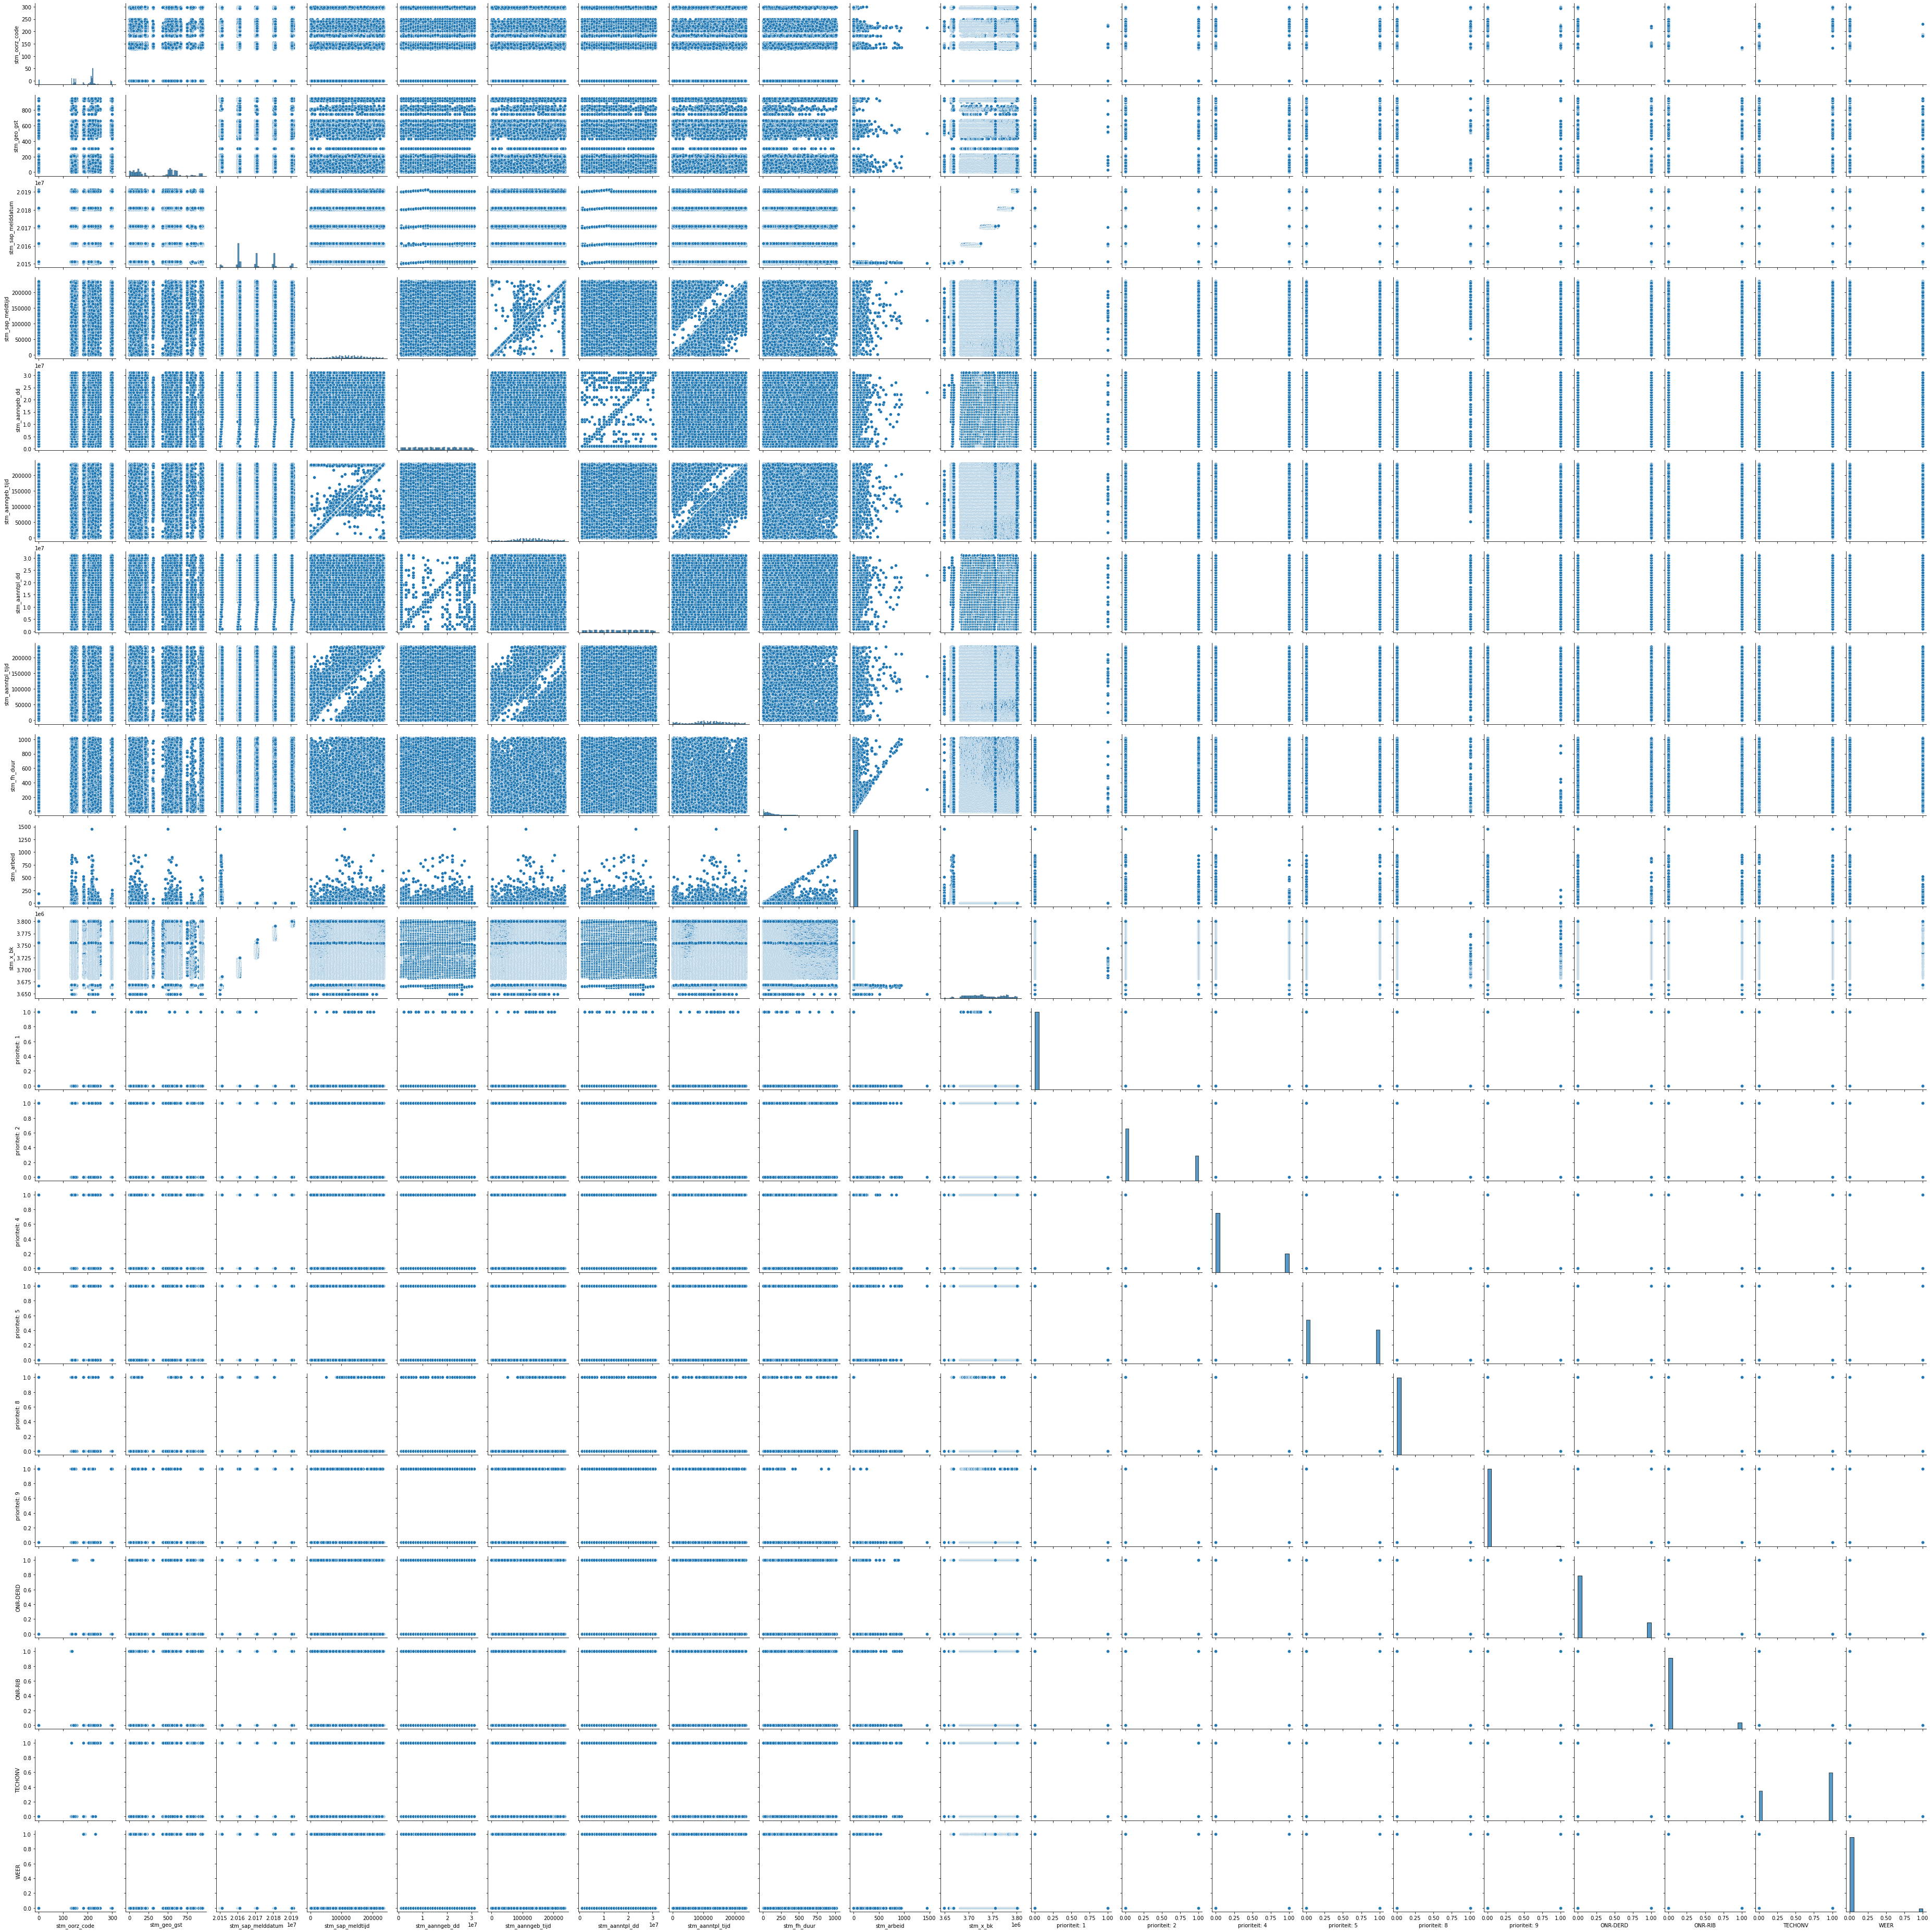

In [36]:
sns.pairplot(storingen)

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Count'>

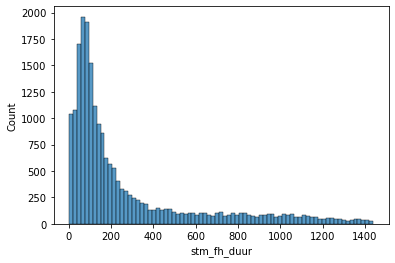

In [89]:
sns.histplot(storingen['stm_fh_duur'])

<AxesSubplot:xlabel='stm_prioriteit', ylabel='Count'>

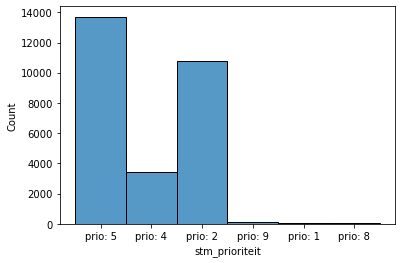

In [107]:
sns.histplot(storingen['stm_prioriteit'])

<AxesSubplot:xlabel='stm_prioriteit', ylabel='stm_fh_duur'>

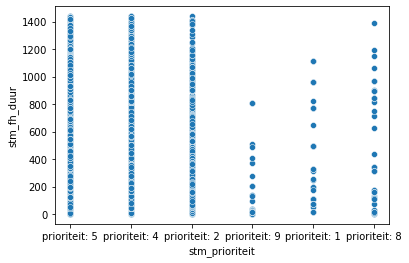

In [98]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_prioriteit'])

<AxesSubplot:xlabel='stm_oorz_groep', ylabel='stm_fh_duur'>

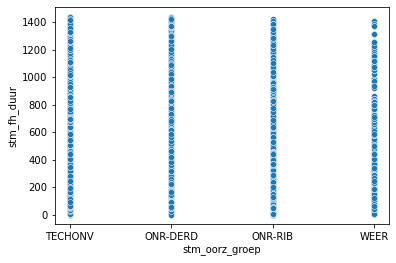

In [87]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_oorz_groep'])

<AxesSubplot:xlabel='stm_oorz_code', ylabel='Count'>

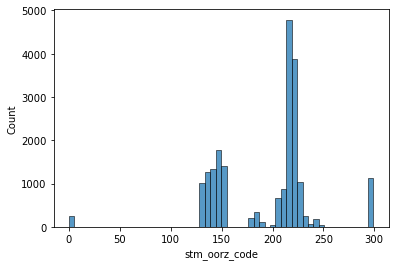

In [63]:
sns.histplot(storingen['stm_oorz_code'])

<AxesSubplot:xlabel='stm_oorz_code', ylabel='stm_fh_duur'>

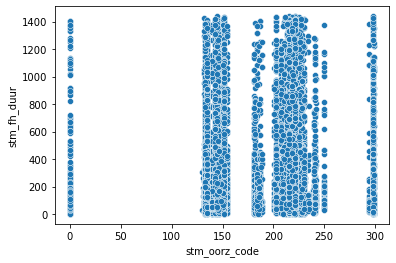

In [62]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_oorz_code'])

<AxesSubplot:xlabel='stm_sap_meldtijd', ylabel='Count'>

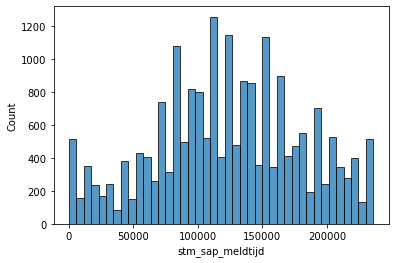

In [61]:
sns.histplot(storingen['stm_sap_meldtijd'])

<AxesSubplot:xlabel='stm_sap_meldtijd', ylabel='stm_fh_duur'>

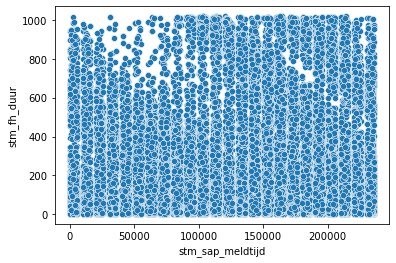

In [329]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_sap_meldtijd'])

<AxesSubplot:xlabel='stm_sap_melddatum', ylabel='stm_fh_duur'>

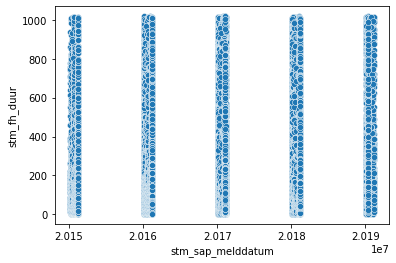

In [328]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_sap_melddatum'])

<AxesSubplot:xlabel='stm_aanntpl_tijd', ylabel='Count'>

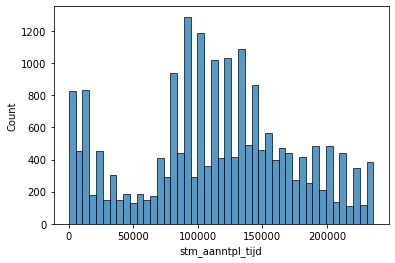

In [59]:
sns.histplot(storingen['stm_aanntpl_tijd'])

<AxesSubplot:xlabel='stm_aanntpl_tijd', ylabel='stm_fh_duur'>

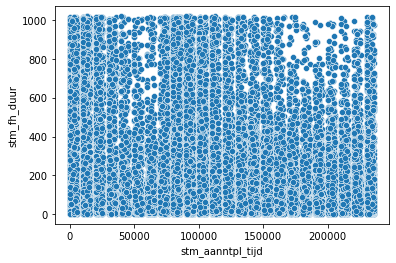

In [330]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_aanntpl_tijd'])

<AxesSubplot:xlabel='stm_fh_duur', ylabel='stm_geo_gst'>

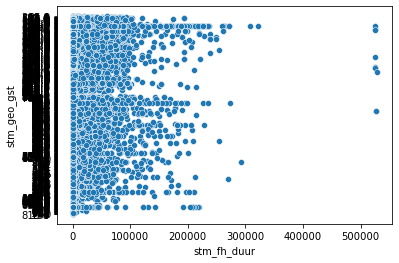

In [57]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_geo_gst'].astype(str))

<AxesSubplot:xlabel='stm_sap_melddatum', ylabel='stm_fh_duur'>

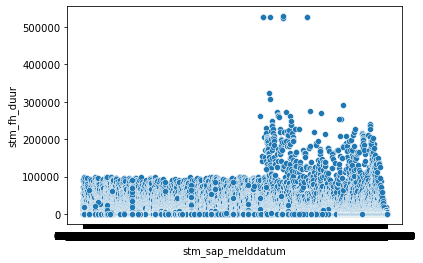

In [48]:
sns.scatterplot(y=storingen['stm_fh_duur'], x=storingen['stm_sap_melddatum'])

# Bijlage 

Hier staan code snippets e.d. die gebruikt zijn, maar uiteindelijk niet nodig waren voor het model.

In [1]:
storingen.describe() #delete me in final version

NameError: name 'storingen' is not defined

In [6]:
print(storingen.isnull().sum().to_string())

stm_oorz_groep            43372
stm_oorz_code             43359
stm_geo_gst              117281
stm_fh_ddt               110568
stm_sap_storeind_ddt     163766
stm_sap_melddatum            30
stm_sap_meldtijd             30
stm_aanngeb_dd            21069
stm_aanngeb_tijd             30
stm_aanntpl_dd           144304
stm_aanntpl_tijd             30
stm_fh_dd                 90098
stm_fh_tijd                  30
stm_fh_duur                  30
stm_sap_storeinddatum    163722
stm_sap_storeindtijd         30
stm_arbeid                   30
stm_x_bk                      0
stm_prioriteit              122


In [61]:
storingen.dtypes

stm_oorz_groep           string
stm_oorz_code             Int64
stm_geo_gst              object
stm_fh_ddt               string
stm_sap_storeind_ddt     string
stm_sap_melddatum        string
stm_sap_meldtijd         string
stm_aanngeb_dd           string
stm_aanngeb_tijd         string
stm_aanntpl_dd           string
stm_aanntpl_tijd         string
stm_fh_dd                string
stm_fh_tijd              string
stm_fh_duur               Int64
stm_sap_storeinddatum    string
stm_sap_storeindtijd     string
stm_prioriteit            Int64
stm_progfh_in_duur       object
dtype: object

In [21]:
storingen.head()

stm_oorz_code  stm_geo_gst           stm_fh_ddt stm_sap_storeind_ddt  \
172035              0          212  04/12/2017 19:55:10                 <NA>   
172036            145          212  04/12/2017 19:55:10  21/12/2017 09:43:00   
172038            143           90  04/12/2017 22:07:00  04/12/2017 22:12:01   
172043            221          506  04/12/2017 22:28:13  04/12/2017 22:29:09   
172046            218          534  05/12/2017 02:37:01  05/12/2017 02:44:00   

        stm_sap_melddatum  stm_sap_meldtijd  stm_aanngeb_dd  stm_aanngeb_tijd  \
172035           20170412            192141         4122017            192646   
172036           20170412            192141         4122017            192646   
172038           20170412            205715         4122017            210326   
172043           20170412            222010         4122017            222306   
172046           20170512              1621         5122017              2620   

        stm_aanntpl_dd  stm_aanntpl_tijd   stm_fh_dd stm_fh_tijd  stm_fh_duur  \
172035         4122017            195326  04/12/2017    19:55:10           28   
172036         4122017            195326  04/12/2017    19:55:10           28   
172038         4122017            220000  04/12/2017    22:07:00           64   
172043         4122017            222343  04/12/2017    22:28:13            5   
172046         5122017             11101  05/12/2017    02:37:01          131   

       stm_sap_storeinddatum stm_sap_storeindtijd  stm_arbeid  stm_x_bk  \
172035                  <NA>             00:00:00           0   3759492   
172036            21/12/2017             09:43:00           0   3759492   
172038            04/12/2017             22:12:01           0   3759493   
172043            04/12/2017             22:29:09           0   3759495   
172046            05/12/2017             02:44:00           0   3759497   

        stm_prioriteit  ONR-DERD  ONR-RIB  TECHONV  WEER  
172035               2         0        0        0     0  
172036               2         1        0        0     0  
172038               5         1        0        0     0  
172043               4         0        0        1     0  
172046               2         0        0        1     0

# Inladen volledige dataset

Allereerst moet de gehele dataset worden ingeladen.

In [15]:
data = pd.read_csv("sap_storing_data_hu_project.csv")
storingen = pd.DataFrame(data=data, index=data.index, columns=['stm_oorz_groep', 'stm_oorz_code','stm_geo_gst', 'stm_fh_ddt',
                                                               'stm_sap_storeind_ddt', 'stm_sap_melddatum', 'stm_sap_meldtijd',
                                                               'stm_aanngeb_dd', 'stm_aanngeb_tijd', 'stm_aanntpl_dd',
                                                               'stm_aanntpl_tijd', 'stm_fh_dd', 'stm_fh_tijd', 'stm_fh_duur',
                                                               'stm_sap_storeinddatum', 'stm_sap_storeindtijd',
                                                               'stm_prioriteit', 'stm_progfh_in_duur'])
storingen = storingen.drop_duplicates()
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Unnamed: 0  #stm_sap_meldnr  stm_mon_nr stm_vl_post     stm_sap_meld_ddt  \
0          0                0         NaN         NaN                  NaN   
1          1         50053211         0.0         NaN  02/01/2006 09:00:00   
2          2         50053213        48.0          GN  02/01/2006 12:35:00   
3          3         50053214        72.0          ZL  02/01/2006 16:40:00   
4          4         50053215        96.0          ZL  02/01/2006 22:30:00   

  stm_sap_mon_meld_ddt                             stm_sap_meldtekst_lang  \
0                  NaN                                                NaN   
1  02/01/2006 09:00:00   Logboeknr  Geeltje  :   49 Tijd: 0900   VL-Po...   
2  02/01/2006 12:35:00   Logboeknr  RBV  :   48 Tijd: 1235   VL-Post: ...   
3  02/01/2006 16:40:00   Logboeknr  RBV  :   72 Tijd: 1640   VL-Post: ...   
4  02/01/2006 22:30:00   Logboeknr  RBV  :   96 Tijd: 2230   VL-Post: ...   

     stm_mon_begin_ddt                         stm_sap_meldtekst  \
0                  NaN                                       NaN   
1                  NaN     Logboeknr  Geeltje  :   49 Tijd: 0900   
2  02/01/2006 12:35:00  Logboeknr  RBV  :   48 Tijd: 1235   VL-P   
3  02/01/2006 16:40:00  Logboeknr  RBV  :   72 Tijd: 1640   VL-P   
4  02/01/2006 22:30:00  Logboeknr  RBV  :   96 Tijd: 2230   VL-P   

  stm_mon_toelichting_trdl stm_oh_pg_mld stm_geo_mld  \
0                      NaN           NaN         NaN   
1                      NaN           NaN       624.0   
2                      NaN           NaN       201.0   
3                      NaN           NaN        25.0   
4                      NaN           NaN        12.0   

   stm_geo_mld_uit_functiepl  stm_equipm_nr_mld stm_equipm_soort_mld  \
0                        NaN                NaN                  NaN   
1                      624.0                NaN                  NaN   
2                      201.0                NaN                  NaN   
3                       25.0                NaN                  NaN   
4                       12.0                NaN                  NaN   

  stm_equipm_omschr_mld  stm_km_van_mld  stm_km_tot_mld  stm_prioriteit  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             0.0             0.0             9.0   
2                   NaN             0.0             0.0             9.0   
3                   NaN             0.0             0.0             9.0   
4                   NaN             0.0             0.0             9.0   

  stm_scenario_mon stm_status_melding_sap stm_mon_nr_status_omschr  \
0              NaN                    NaN                      NaN   
1              NaN              MAFS MAFD                      NaN   
2              NaN                   MAFS        Aan AM toegewezen   
3              NaN              MAFS MAFD        Aan AM toegewezen   
4              NaN                   MAFS        Aan AM toegewezen   

   stm_mon_nr__statuscode stm_mon_nr_status_wijzdd      stm_aanngeb_ddt  \
0                     NaN                      NaN                  NaN   
1                     NaN               00/00/0000  02/01/2006 09:00:00   
2                     0.0               03/01/2006  02/01/2006 12:35:00   
3                     0.0               03/01/2006  02/01/2006 16:40:00   
4                     0.0               03/01/2006  02/01/2006 22:30:00   

  stm_aanntpl_ddt stm_oh_pg_gst stm_geo_gst  stm_geo_gst_uit_functiepl  \
0             NaN           NaN         NaN                        NaN   
1             NaN           81S       624.0                      624.0   
2             NaN           37B       201.0                      201.0   
3             NaN           32B        25.0                       25.0   
4             NaN           35B        12.0                       12.0   

   stm_equipm_nr_gst stm_equipm_soort_gst stm_equipm_omschr_gst  \
0                NaN                  NaN               

# Verwijderen van de n.v.t. kolommen

De opdrachtgever heeft aangegeven dat een aantal kolommen n.v.t. zijn, daarnaast zijn er nog meer kolommen die niet van toepassing zijn, zoals bijvoorbeeld database modifiers en de tijd dat de storing is opgelost. Deze laatste is niet van toepassign omdat je deze niet van te voren in kan voeren. De overgebleven kolommen worden in de dataset geladen. Daarnaast worden ook de duplicaten verwijderd, de eerste lege regel verwijderd, en de datatypes omgezet tot het best passende formaat.

In [4]:
storingen = pd.DataFrame(data=storingen, index=storingen.index, columns=['stm_prioriteit', 'stm_aanntpl_tijd', 'stm_progfh_in_duur',
                                                               'stm_sap_meldtijd', 'stm_fh_duur'])
storingen = storingen.iloc[1: , :]
#storingen = storingen.drop_duplicates()
storingen = storingen.convert_dtypes()
storingen.head()
#print(len(storingen))

stm_prioriteit stm_aanntpl_tijd stm_progfh_in_duur stm_sap_meldtijd  \
1               9         00:00:00         99999999.0         09:00:00   
2               9         00:00:00         99999999.0         12:35:00   
3               9         00:00:00         99999999.0         16:40:00   
4               9         00:00:00         99999999.0         22:30:00   
5               9         00:00:00         99999999.0         11:23:00   

   stm_fh_duur  
1            0  
2           51  
3           40  
4            6  
5            7

In [5]:
storingen.to_csv(path_or_buf='clean.csv', index=False)

# Data cleanup - unused

Hieronder wordt een nieuwe code aangemaakt voor onbekende stm_ooz_codes, 0.

In [76]:
storingen['stm_oorz_code'] = storingen['stm_oorz_code'].astype(str)
storingen['stm_oorz_code'] = storingen['stm_oorz_code'].str.replace('<NA>', '0')
storingen['stm_oorz_code'] = storingen['stm_oorz_code'].fillna('0')
storingen['stm_oorz_code'] = storingen['stm_oorz_code'].astype(int)

Hieronder worden alle stm_geo_gst die niet numeriek zijn, verwijderd, zodat deze hele kolom kan worden omgezet tot een int. Hierdoor kan het model hiermee kan werken.

In [78]:
storingen =  storingen[storingen.stm_geo_gst.astype(str).apply(lambda x: x.isnumeric())]
storingen["stm_geo_gst"] = storingen["stm_geo_gst"].astype(int)

In [79]:
storingen["stm_sap_melddatum"] = pd.to_datetime(storingen["stm_sap_melddatum"])
storingen["stm_sap_melddatum"] = storingen["stm_sap_melddatum"].dropna().apply(lambda a: int(a.strftime('%Y%m%d')))
storingen["stm_sap_melddatum"] = storingen["stm_sap_melddatum"].astype(int)

In [81]:
storingen["stm_aanntpl_dd"] = storingen["stm_aanntpl_dd"].str.replace("/", "")
storingen = storingen[storingen.stm_aanntpl_dd != '']
storingen["stm_aanntpl_dd"] = storingen["stm_aanntpl_dd"].dropna()
storingen["stm_aanntpl_dd"] = storingen["stm_aanntpl_dd"].astype(int)

In [83]:
storingen["stm_aanngeb_dd"] = storingen["stm_aanngeb_dd"].str.replace("/", "")
storingen = storingen[storingen.stm_aanngeb_dd != '']
storingen["stm_aanngeb_dd"] = storingen["stm_aanngeb_dd"].dropna()
storingen["stm_aanngeb_dd"] = storingen["stm_aanngeb_dd"].astype(int)

In [84]:
storingen["stm_aanngeb_tijd"] = storingen["stm_aanngeb_tijd"].str.replace(":", "")
storingen = storingen[storingen.stm_aanngeb_tijd != '']
storingen["stm_aanngeb_tijd"] = storingen["stm_aanngeb_tijd"].dropna()
storingen["stm_aanngeb_tijd"] = storingen["stm_aanngeb_tijd"].astype(int)

Hieronder worden dummies aangemaakt voor stm_oporzaak_groep.

In [85]:
dummies = pd.get_dummies(storingen['stm_oorz_groep'])
storingen = storingen.drop('stm_oorz_groep',axis = 1)
storingen = storingen.join(dummies)

In [35]:
storingen['stm_sap_meldtijd'] = storingen['stm_sap_meldtijd'].str.replace("::", "00:00:00")
storingen['stm_sap_meld_ddt'] = pd.to_datetime(storingen.stm_sap_melddatum[storingen.stm_sap_melddatum != '00000000'].dropna().astype(str) + ' ' + storingen.stm_sap_meldtijd[storingen.stm_sap_meldtijd != '00:00:00'].dropna().astype(str))

stm_oorz_code  stm_geo_gst           stm_fh_ddt stm_sap_storeind_ddt  \
542417            227          516  04/12/2015 11:37:00                 <NA>   
542418            227          516  04/12/2015 11:37:00  23/03/2016 16:00:00   
542419            228          118  04/12/2015 12:35:00  04/12/2015 12:35:00   
542420            143          105  04/12/2015 13:15:00  08/12/2015 10:34:00   
542431            215          620  04/12/2015 15:25:00  07/12/2015 11:02:00   

        stm_sap_melddatum  stm_sap_meldtijd  stm_aanngeb_dd  stm_aanngeb_tijd  \
542417           20150412             95919         4122015             95919   
542418           20150412             95919         4122015             95919   
542419           20150412            100042         4122015            100042   
542420           20150412            100529         4122015            100529   
542431           20150412            105712         4122015            105712   

        stm_aanntpl_dd  stm_aanntpl_tijd   stm_fh_dd stm_fh_tijd  stm_fh_duur  \
542417         4122015            110000  04/12/2015    11:37:00           98   
542418         4122015            110000  04/12/2015    11:37:00           98   
542419         4122015            104100  04/12/2015    12:35:00          154   
542420         4122015            101100  04/12/2015    13:15:00          190   
542431         4122015            143300  04/12/2015    15:25:00          268   

       stm_sap_storeinddatum stm_sap_storeindtijd  stm_progfh_in_duur  \
542417                  <NA>             00:00:00                  60   
542418            23/03/2016             16:00:00                  60   
542419            04/12/2015             12:35:00                 114   
542420            08/12/2015             10:34:00                 184   
542431            07/12/2015             11:02:00                  52   

        prioriteit: 1  prioriteit: 2  prioriteit: 4  prioriteit: 5  \
542417              0              0              0              1   
542418              0              0              0              1   
542419              0              1              0              0   
542420              0              0              0              1   
542431              0              0              0              1   

        prioriteit: 8  prioriteit: 9  ONR-DERD  ONR-RIB  TECHONV  WEER  
542417              0              0         0        0        1     0  
542418              0              0         0        0        1     0  
542419              0              0         0        0        1     0  
542420              0              0         1        0        0     0  
542431              0              0         0        0        1     0